<a href="https://colab.research.google.com/github/sohumgautam17/Cell_Seg_Count-CMU/blob/main/CMU_CSegNET_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cell Segmentation Imports

In [13]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

mps_device = torch.device('mps')

tensor([1.], device='mps:0')


In [14]:
import torch
import sklearn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import requests
from pathlib import Path
import xml.etree.ElementTree as ET
from PIL import Image
from torch import nn
import torch.nn.functional as F
import sys

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from tqdm.auto import tqdm
from torchvision.transforms.functional import hflip, vflip
import torchinfo
from torchinfo import summary
import glob


/Users/sohumgautam/opt/miniconda3/envs/cmu_sohum_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
if 'WANDB_API_KEY' not in os.environ:
    os.environ['WANDB_API_KEY'] = '701f8ca984f721ff516ad75d281121cb10d18f83'

In [16]:
import wandb
wandb.login()

True

#Download and Parse CryoNuSeg + Augmentations


In [17]:
from process_data import load_cryo, resize_cryo
cryo_images, cryo_annotations = load_cryo()

(512, 512, 3)
(512, 512, 3)


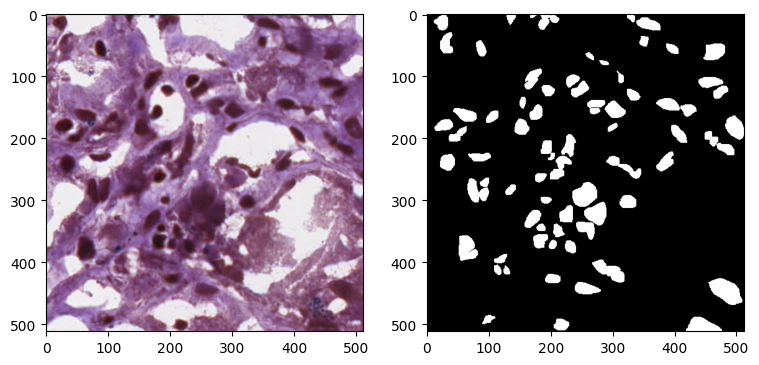

In [18]:
image = 1
ex_image = cryo_images[image - 1]
ex_annotation = cryo_annotations[image - 1]
fig, ax = plt.subplots(1, 2, figsize=(9,9))
ax[0].imshow(ex_image)
print(ex_image.shape)
ax[1].imshow(ex_annotation)
print(ex_annotation.shape)

In [19]:
import torchvision.transforms as T
resize_cryo, resize_mask = resize_cryo(cryo_images=cryo_images, cryo_annotations=cryo_annotations)

(1000, 1000, 3)
(1000, 1000)


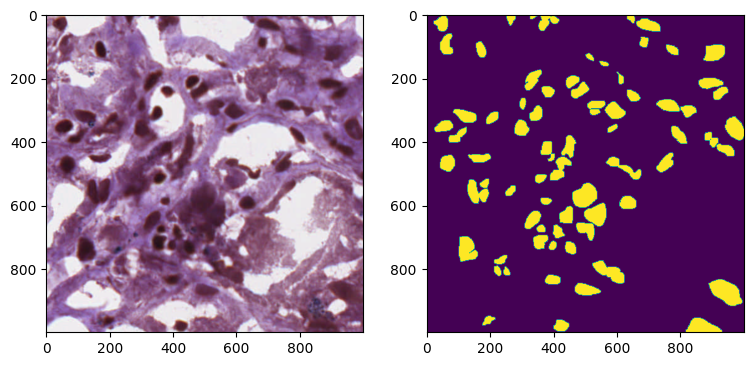

In [20]:
#Resized_Img_array, resized_mask_array is where all resized 1000,1000 images are 
num_image = 0
fig, ax = plt.subplots(1, 2, figsize=(9,9))
ax[0].imshow(resize_cryo[num_image])
print(resize_cryo[num_image].shape)
ax[1].imshow(resize_mask[num_image]) 
print(resize_mask[num_image].shape) #This should not have 3 channels


#Download and Parse MoNuSeg + Augmentaitons

In [21]:
from process_data import load_monuseg
images_and_masks = load_monuseg()

In [22]:
monu_images = []
monu_masks = []
for item in images_and_masks:
    monu_images.append(item['original_image'])
    monu_masks.append(item['binary_mask'])

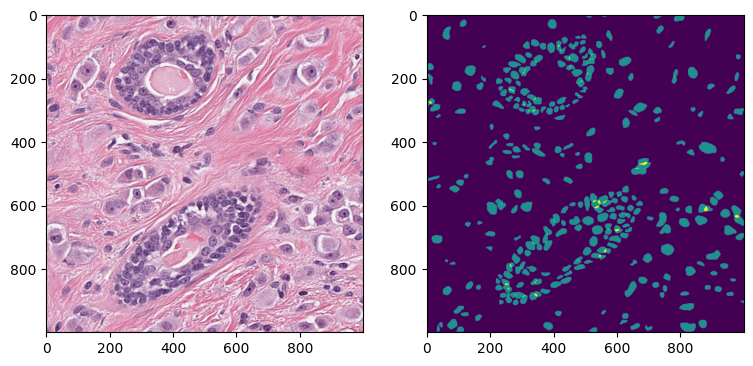

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(9,9))
ax[0].imshow(monu_images[1])
ax[1].imshow(monu_masks[1])

Compile Datasets & Split for Train Test

In [24]:
X_before_aug = monu_images + resize_cryo
y_before_aug = monu_masks + resize_mask
print(f'images: {len(X_before_aug)}, masks: {len(y_before_aug)}')
test_image, test_mask = X_before_aug[1], y_before_aug[1]

images: 60, masks: 60


In [25]:
from augmentations import apply_aug

#These lists contain stacks of all the augmentations len=60
augmented_images = []
augmented_masks = []
for image, mask in zip(X_before_aug, y_before_aug):
    augmentations = apply_aug(image, mask)
    aug_images = augmentations['images']
    aug_masks = augmentations['masks']
    augmented_images.append(aug_images)
    augmented_masks.append(aug_masks)
    # Process aug_images and aug_masks as needed

#After extending all stack, the total image, mask count is 420, 420 (7 augmentations per image(60))
all_augmented_images = []
for stack in augmented_images:
    all_augmented_images.extend(stack)

all_augmented_masks = []
for stack in augmented_masks:
    all_augmented_masks.extend(stack)


/Users/sohumgautam/opt/miniconda3/envs/cmu_sohum_env/lib/python3.8/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


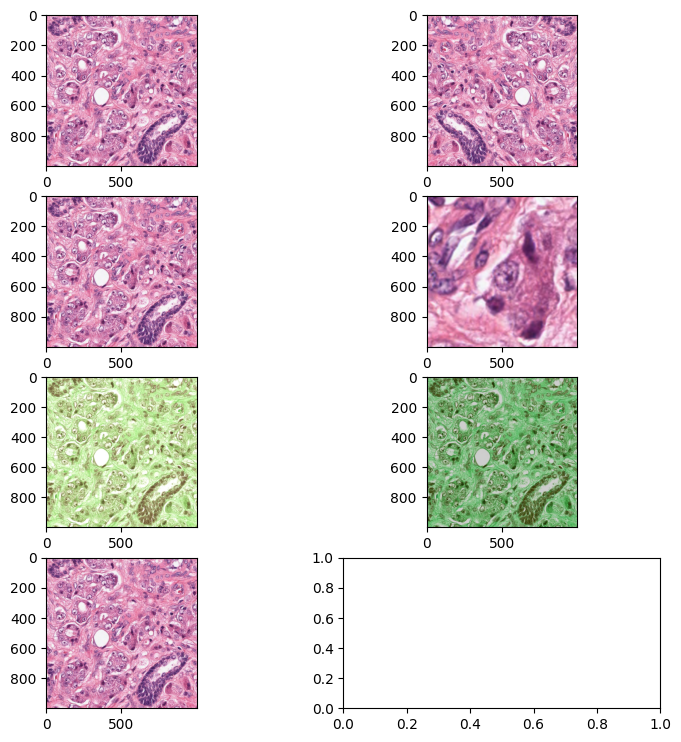

In [26]:
fig, ax = plt.subplots(4, 2, figsize=(9,9))
ax[0][0].imshow(augmented_images[0][0])
ax[0][1].imshow(augmented_images[0][1])
ax[1][0].imshow(augmented_images[0][2])
ax[1][1].imshow(augmented_images[0][3])
ax[2][0].imshow(augmented_images[0][4])
ax[2][1].imshow(augmented_images[0][5])
ax[3][0].imshow(augmented_images[0][6])

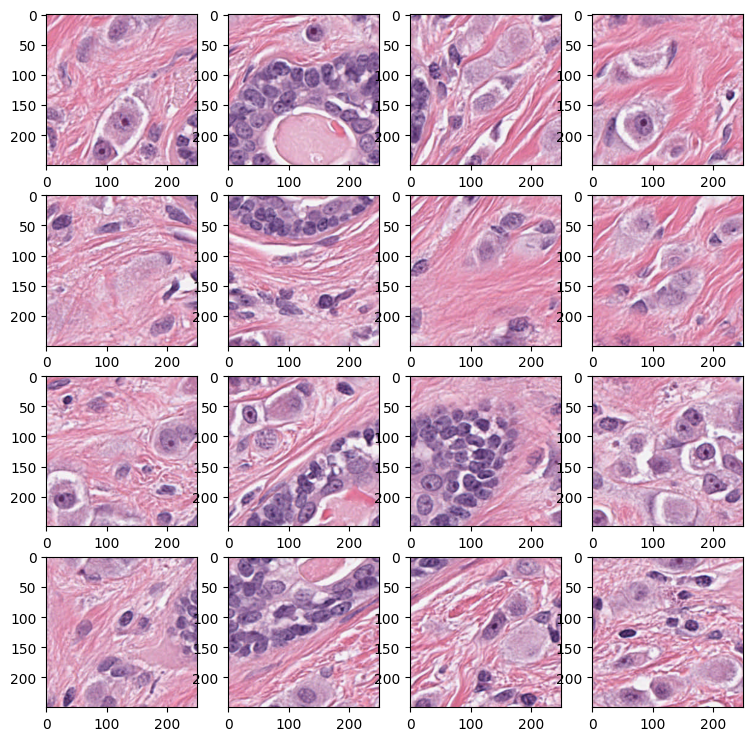

In [27]:
from resize_and_patching import split_image_into_patches, split_mask_into_patches
images = split_image_into_patches(test_image, patch_size=250)
row, col = 4, 4
fig, ax = plt.subplots(row, col, figsize=(9, 9))
for i in range(row):
    for j in range(col):
        idx = i * 4 + j
        ax[i][j].imshow(images[idx])

In [28]:
image_patches = []
mask_patches = []
for image in all_augmented_images:
    patches = split_image_into_patches(image)
    image_patches.append(patches)

for mask in all_augmented_masks:
    patches = split_mask_into_patches(mask)
    mask_patches.append(patches)

# All Training images and labels are now stored in these
X_images = [patch for patches in image_patches for patch in patches]
y_masks = [mask for masks in mask_patches for mask in masks]
print(f'flattened images count : {len(X_images)}, flattened mask count : {len(y_masks)}')
print(f'image shape : {X_images[0].shape}, mask shape : {y_masks[0].shape}')


flattened images count : 6720, flattened mask count : 6720
image shape : (250, 250, 3), mask shape : (250, 250)


In [29]:
print(X_images[1].dtype)

uint8


#Getting Data Ready for Batching

#Setup Configs + Batching



In [30]:
EPOCHS = 5

BATCH_SIZE = 32
learning_rate = 0.05
test_ratio = 0.1

# ENCODER = 'timm-efficientnet-b7'
# WEIGHTS = 'imagenet'

In [31]:
X, y = np.array(X_images), np.array(y_masks)
X, y = torch.Tensor(X), torch.Tensor(y)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
print(len(X_train)), print(len(y_train)), print(len(X_test)), print(len(y_test)), 

6048
6048
672
672


(None, None, None, None)

In [33]:
train_set = TensorDataset(X_train, y_train)
test_set = TensorDataset(X_test, y_test)

In [34]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_loader)), print(len(test_loader))


189
21


(None, None)

#Segmentation Model ... Temporary until the model file is built

In [35]:
from models import UNet

n_channels = 3
out_channels = 1 # output shape is H W C and a mask should have 1 channel
bilinear = True

model_0 = UNet(n_channels, out_channels, bilinear)
model_0

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [36]:
summary(model_0)

Layer (type:depth-idx)                        Param #
UNet                                          --
├─DoubleConv: 1-1                             --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       1,792
│    │    └─BatchNorm2d: 3-2                  128
│    │    └─ReLU: 3-3                         --
│    │    └─Conv2d: 3-4                       36,928
│    │    └─BatchNorm2d: 3-5                  128
│    │    └─ReLU: 3-6                         --
├─Down: 1-2                                   --
│    └─Sequential: 2-2                        --
│    │    └─MaxPool2d: 3-7                    --
│    │    └─DoubleConv: 3-8                   221,952
├─Down: 1-3                                   --
│    └─Sequential: 2-3                        --
│    │    └─MaxPool2d: 3-9                    --
│    │    └─DoubleConv: 3-10                  886,272
├─Down: 1-4                                   --
│    └─Sequential: 2-4                       

In [37]:
num_params = sum(p.numel() for p in model_0.parameters())
num_params

31390721

#Metrics

In [38]:
DICE_loss = DiceLoss(mode='binary')
BCE_loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=learning_rate)

In [39]:
def accuracy_metric(pred, gt):
  with torch.no_grad():
    pred = torch.argmax(F.softmax(pred, dim=1), dim=1)
    correct = torch.eq(pred, gt).int()
    accuracy = (float(correct.sum()))/float(correct.numel())
  return accuracy


In [40]:
for batch_idx, (image, annote) in enumerate(train_loader):
    # Display the first image in the batch
    if batch_idx == 1:

    # Permute dimensions for model input
        image = image.permute(0, 3, 1, 2)
        print(image.shape)
        print(image.dtype)


torch.Size([32, 3, 250, 250])
torch.float32


In [52]:
def train(model, optimizer):
    model.train()
    total_train_loss = 0
    train_losses = []
    #eval_losses = []
    print(f"Number of Images Trained on: {len(X_train)} | # Epochs: {EPOCHS} | LR: {learning_rate} | Number of Params: {num_params}")

    wandb.init(
        project='Cellseg_research',
        config={
            'epochs': EPOCHS,
            'batch_size': BATCH_SIZE,
            'learning_rate': learning_rate,
                        
        }
    )
    
    for epoch in tqdm(range(EPOCHS)):
        epoch_train_loss = 0
        for batch_idx, (image, annote) in enumerate(train_loader):
            
            

        
            image = image.permute(0, 3, 1, 2) # This is because the image was originally in size (32, 250, 250, 3), Torch doesnt like this
            
            logits = model(image)
            annote = annote.unsqueeze(1)

            dice_loss = DICE_loss(logits, annote)
            bce_loss = BCE_loss(logits, annote)
            loss = dice_loss + bce_loss

            


            if batch_idx % 30 == 0:
                print(f"Epoch #{epoch}_______Batch #{batch_idx}...")
                print(f"Dice Loss: {dice_loss.item()}  BCE Loss: {bce_loss.item()}")

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()



        wandb.log({
                "batch_dice_loss": dice_loss,
                "batch_bce_loss": bce_loss,
                "total_loss":loss,
            })
        


        epoch_train_loss /= len(train_loader)
        total_train_loss += epoch_train_loss
        print(f"Epoch {epoch} Train Loss: {epoch_train_loss}")

    
    total_train_loss /= EPOCHS
    train_losses.append(total_train_loss)
    print(f"Total Training Loss: {total_train_loss}")
    return total_train_loss

In [53]:
def test(model):
    model.eval()
    total_dice_loss = 0
    total_bce_loss = 0

    with torch.no_grad():
        for image, annote in test_loader:
            test_logits = model(image)
            annote = annote.unsqueeze(1)  # Ensure the annotation shape matches the logits shape if needed

            dice_loss = DICE_loss(test_logits, annote)
            bce_loss = BCE_loss(test_logits, annote)


            total_dice_loss += dice_loss.item()
            total_bce_loss += bce_loss.item()

    avg_dice_loss = total_dice_loss / len(test_loader)
    avg_bce_loss = total_bce_loss / len(test_loader)

    return print(f'DICEL: {avg_dice_loss}, BCEL: {avg_bce_loss}')

In [49]:
#Debugging and Test Case
image, annote = next(iter(train_loader))
image = image.permute(0, 3, 1, 2) 
logits = model_0(image)
annote = annote.unsqueeze(1)

dice_loss = DICE_loss(logits, annote)
bce_loss = BCE_loss(logits, annote)
loss = dice_loss + bce_loss

print(f"Logits: {logits}")
print(f"Annotation: {annote}")
print(f"Dice Loss: {dice_loss.item()}  BCE Loss: {bce_loss.item()}  Combined Loss: {loss.item()}")


Logits: tensor([[[[-1.8307e-01,  9.3971e-01,  8.1874e-01,  ...,  5.8935e-01,
            1.4623e+00,  9.2021e-01],
          [ 3.9651e-01,  2.4538e-01,  2.4061e-01,  ...,  2.0040e-01,
            7.8633e-01,  1.2729e+00],
          [ 8.8218e-02, -6.2834e-04,  3.9977e-02,  ..., -1.8779e-01,
            2.8903e-02,  7.9238e-01],
          ...,
          [ 1.3409e-01, -1.2995e-01,  3.0859e-02,  ...,  2.9373e-01,
            2.6142e-01, -1.5590e-01],
          [ 2.3870e-01, -6.1708e-02,  4.1660e-01,  ...,  5.3099e-01,
            7.1370e-01,  5.4528e-01],
          [ 2.0472e-01,  2.9320e-01, -1.1884e-01,  ..., -7.1583e-03,
           -1.5195e-01,  2.4783e-01]]],


        [[[ 8.8425e-02,  5.3600e-01,  7.1358e-01,  ...,  7.1142e-01,
            1.5209e+00,  7.5022e-01],
          [ 1.2399e-01,  1.6903e-01,  1.8462e-02,  ...,  3.1323e-01,
            6.6136e-01,  1.0097e+00],
          [ 1.0194e+00,  9.7654e-02, -2.3598e-01,  ...,  2.8668e-02,
            3.9162e-02,  5.0615e-01],
          

In [ ]:
train(model_0, optimizer)

Inference

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

image = X_test[3]
image = image / 255.0

image_for_visualization = torch.permute(image, (1, 2, 0))
print(image_for_visualization.shape)

image_for_visualization = image_for_visualization.numpy()
image_for_visualization = np.clip(image_for_visualization, 0, 1)

image = image.unsqueeze(0)  # Add batch dimension bc model expects it

output = model_0(image)

print("Output shape:", output.shape)

output_image = output.squeeze(0).permute(1, 2, 0).detach().numpy()

# Ensure the data is in the valid range for imshow
output_image = np.clip(output_image, 0, 1)

fig, ax = plt.subplots(1, 2, figsize=(9, 9))
ax[0].imshow(image_for_visualization)
ax[0].set_title("Original")

ax[1].imshow(output_image)
ax[1].set_title("Transformed")

plt.show()


In [ ]:
#Visualize Prediction Images
image = X[3]
#print(image.shape), print(image.dtype)
#plt.imshow(image)
image = image.numpy()
image = np.clip(image, 0, 1)
image = image.unsqueeze(0)  # Add batch dimension

# image = torch.Tensor(image)
output = model_0(image)
output_image = output.squeeze().permute(1, 2, 0).detach().numpy()
output_image = np.clip(output_image, 0, 1)

fig, ax = plt.subplots(1, 2, figsize=(9, 9))
ax[0].imshow(image)
ax[1].imshow(output_image)

In [ ]:
from pathlib import Path

MODEL_PATH = Path("/content/Cell_Seg_Count-CMU-main")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "fully_trained_seg_unet1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
#MODEL_SAVE_PATH

print(f'Saving model to {MODEL_SAVE_PATH}')
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

In [ ]:
trained_model_PATH = 'fully_trained_seg_unet1.pth'
UNET_model = UNet(n_channels, out_channels, bilinear)
UNET_model.load_state_dict(torch.load(trained_model_PATH))
UNET_model.eval()
with torch.inference_mode():
  test(model_0)

In [ ]:
for image, annote in test_loader:
  output = UNET_model(image)
  accuracy = accuracy_metric(output, annote)
  print(accuracy)